In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

print(f"TensorFlow version: {tf.__version__}")

from src_numpy import (
    particle_filter_numpy,
    make_random_walk_ssm_np,
    make_range_bearing_ssm_np,
    make_linear_gaussian_ssm_np
)

from src.filters import (
    kalman_filter,
    ekf_filter,
    ukf_filter
)

TensorFlow version: 2.20.0


=== 2D LGSSM Kalman Filter Results ===
RMSE (position): 0.6757
RMSE (velocity): 0.4321


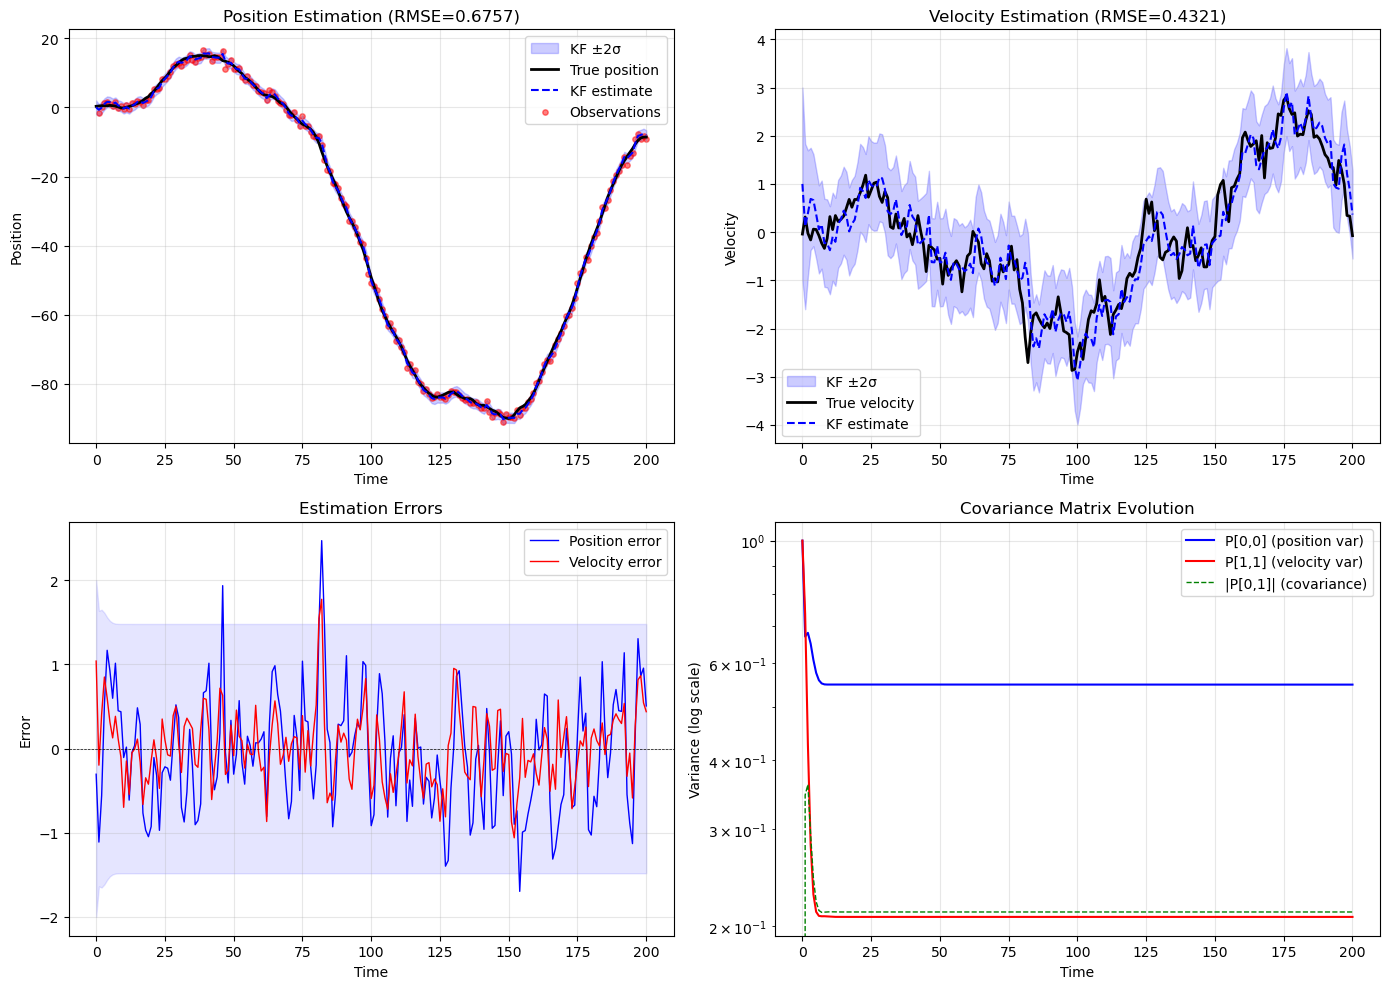

In [2]:
def example_2d_lgssm(T=200, seed=42):
    dtype = tf.float64
    
    # --- Model parameters ---
    dt = 1.0
    
    # Transition: x_t = A @ x_{t-1} + noise
    A = np.array([
        [1.0, dt],
        [0.0, 1.0]
    ])
    
    # Observation: y_t = C @ x_t + noise (observe position only)
    C = np.array([[1.0, 0.0]])
    
    # Process noise covariance
    q = 0.1
    Q = q * np.array([
        [dt**3/3, dt**2/2],
        [dt**2/2, dt]
    ])
    
    # Observation noise covariance
    R = np.array([[1.0]])
    
    # Initial state
    m0 = np.array([0.0, 1.0])  # Start at origin with velocity 1
    P0 = np.array([
        [1.0, 0.0],
        [0.0, 1.0]
    ])
    
    # --- Create NumPy SSM and simulate ---
    ssm = make_linear_gaussian_ssm_np(A=A, C=C, Q=Q, R=R, m0=m0, P0=P0)
    xs_true, ys = ssm.simulate(T=T, seed=seed)
    
    # --- Run Kalman Filter (TF implementation) ---
    ys_tf = tf.convert_to_tensor(ys, dtype=dtype)
    A_tf = tf.constant(A, dtype=dtype)
    C_tf = tf.constant(C, dtype=dtype)
    B_tf = tf.constant(np.linalg.cholesky(Q), dtype=dtype)  # BB^T = Q
    D_tf = tf.constant(np.linalg.cholesky(R), dtype=dtype)  # DD^T = R
    m0_tf = tf.constant(m0, dtype=dtype)
    P0_tf = tf.constant(P0, dtype=dtype)
    
    ms_kf, Ps_kf = kalman_filter(
        ys_tf, A_tf, B_tf, C_tf, D_tf, m0_tf, P0_tf, eps=0.0, dtype=dtype
    )
    ms_kf = ms_kf.numpy()
    Ps_kf = Ps_kf.numpy()
    
    # --- Compute RMSE ---
    rmse_pos = np.sqrt(np.mean((ms_kf[:, 0] - xs_true[:, 0])**2))
    rmse_vel = np.sqrt(np.mean((ms_kf[:, 1] - xs_true[:, 1])**2))
    
    print("=== 2D LGSSM Kalman Filter Results ===")
    print(f"RMSE (position): {rmse_pos:.4f}")
    print(f"RMSE (velocity): {rmse_vel:.4f}")
    
    # --- Visualization ---
    t = np.arange(T + 1)
    t_obs = np.arange(1, T + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Position estimation
    ax1 = axes[0, 0]
    std_pos = np.sqrt(Ps_kf[:, 0, 0])
    ax1.fill_between(t, ms_kf[:, 0] - 2*std_pos, ms_kf[:, 0] + 2*std_pos,
                     color='blue', alpha=0.2, label='KF ±2σ')
    ax1.plot(t, xs_true[:, 0], 'k-', lw=2, label='True position')
    ax1.plot(t, ms_kf[:, 0], 'b--', lw=1.5, label='KF estimate')
    ax1.scatter(t_obs, ys[:, 0], s=15, c='red', alpha=0.5, label='Observations')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Position')
    ax1.set_title(f'Position Estimation (RMSE={rmse_pos:.4f})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Velocity estimation
    ax2 = axes[0, 1]
    std_vel = np.sqrt(Ps_kf[:, 1, 1])
    ax2.fill_between(t, ms_kf[:, 1] - 2*std_vel, ms_kf[:, 1] + 2*std_vel,
                     color='blue', alpha=0.2, label='KF ±2σ')
    ax2.plot(t, xs_true[:, 1], 'k-', lw=2, label='True velocity')
    ax2.plot(t, ms_kf[:, 1], 'b--', lw=1.5, label='KF estimate')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Velocity')
    ax2.set_title(f'Velocity Estimation (RMSE={rmse_vel:.4f})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Estimation errors
    ax3 = axes[1, 0]
    err_pos = ms_kf[:, 0] - xs_true[:, 0]
    err_vel = ms_kf[:, 1] - xs_true[:, 1]
    ax3.plot(t, err_pos, 'b-', lw=1, label='Position error')
    ax3.plot(t, err_vel, 'r-', lw=1, label='Velocity error')
    ax3.axhline(0, color='k', lw=0.5, ls='--')
    ax3.fill_between(t, -2*std_pos, 2*std_pos, color='blue', alpha=0.1)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Error')
    ax3.set_title('Estimation Errors')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Covariance evolution (diagonal elements)
    ax4 = axes[1, 1]
    ax4.semilogy(t, Ps_kf[:, 0, 0], 'b-', lw=1.5, label='P[0,0] (position var)')
    ax4.semilogy(t, Ps_kf[:, 1, 1], 'r-', lw=1.5, label='P[1,1] (velocity var)')
    ax4.semilogy(t, np.abs(Ps_kf[:, 0, 1]), 'g--', lw=1, label='|P[0,1]| (covariance)')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Variance (log scale)')
    ax4.set_title('Covariance Matrix Evolution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return xs_true, ys, ms_kf, Ps_kf


# Run 2D LGSSM example
xs_true, ys, ms_kf, Ps_kf = example_2d_lgssm(T=200, seed=42)

In [3]:
def analyze_conditioning_vs_R(R_values=None, T=50, seed=42):
    """
    Analyze conditioning number of covariance matrix as R decreases.
    """
    if R_values is None:
        R_values = [1.0, 1e-6, 1e-12, 1e-15, 1e-16, 1e-17, 1e-18]
    
    # 1D Random Walk model
    A = np.array([[1.0]])
    C = np.array([[1.0]])
    Q = np.array([[0.2]])
    m0 = np.array([0.0])
    P0 = np.array([[1.0]])
    
    # Storage for analysis
    results = {
        'R': [],
        'cond_number_standard': [],
        'cond_number_joseph': [],
        'min_eigenvalue_standard': [],
        'min_eigenvalue_joseph': [],
        'is_pd_standard': [],
        'is_pd_joseph': [],
    }
    
    print("="*70)
    print("Conditioning Analysis: Standard vs Joseph Update")
    print("="*70)
    print(f"{'R':>12} | {'Cond(Std)':>12} | {'Cond(Jos)':>12} | {'MinEig(Std)':>14} | {'MinEig(Jos)':>14}")
    print("-"*70)
    
    for R_val in R_values:
        R = np.array([[R_val]])
        
        # --- Standard Kalman Update (potentially unstable) ---
        P_pred = P0.copy()
        P_standard_history = []
        cond_standard_history = []
        
        for t in range(T):
            # Predict
            P_pred = A @ P_pred @ A.T + Q
            
            # Standard update: P = (I - KH) P_pred
            S = C @ P_pred @ C.T + R
            K = P_pred @ C.T @ np.linalg.inv(S)
            P_upd = (np.eye(1) - K @ C) @ P_pred
            
            P_standard_history.append(P_upd.copy())
            cond_standard_history.append(np.linalg.cond(P_upd))
            P_pred = P_upd
        
        # --- Joseph Stabilized Update ---
        P_pred = P0.copy()
        P_joseph_history = []
        cond_joseph_history = []
        
        for t in range(T):
            # Predict
            P_pred = A @ P_pred @ A.T + Q
            
            # Joseph update: P = (I-KH) P_pred (I-KH)' + K R K'
            S = C @ P_pred @ C.T + R
            K = P_pred @ C.T @ np.linalg.inv(S)
            IKH = np.eye(1) - K @ C
            P_upd = IKH @ P_pred @ IKH.T + K @ R @ K.T
            P_upd = 0.5 * (P_upd + P_upd.T)  # Ensure symmetry
            
            P_joseph_history.append(P_upd.copy())
            cond_joseph_history.append(np.linalg.cond(P_upd))
            P_pred = P_upd
        
        # Final covariance analysis
        P_final_std = P_standard_history[-1]
        P_final_jos = P_joseph_history[-1]
        
        cond_std = np.linalg.cond(P_final_std)
        cond_jos = np.linalg.cond(P_final_jos)
        
        eig_std = np.linalg.eigvalsh(P_final_std)
        eig_jos = np.linalg.eigvalsh(P_final_jos)
        
        min_eig_std = np.min(eig_std)
        min_eig_jos = np.min(eig_jos)
        
        is_pd_std = min_eig_std > 0
        is_pd_jos = min_eig_jos > 0
        
        results['R'].append(R_val)

        if cond_std == float("inf"):
            results['cond_number_standard'].append(10**3)
        else:
            results['cond_number_standard'].append(cond_std)

        results['cond_number_joseph'].append(cond_jos)
        results['min_eigenvalue_standard'].append(min_eig_std)
        results['min_eigenvalue_joseph'].append(min_eig_jos)
        results['is_pd_standard'].append(is_pd_std)
        results['is_pd_joseph'].append(is_pd_jos)
        
        pd_std_str = "✓" if is_pd_std else "✗"
        pd_jos_str = "✓" if is_pd_jos else "✗"
        
        print(f"{R_val:>12.0e} | {cond_std:>12.2e} | {cond_jos:>12.2e} | {min_eig_std:>14.2e} {pd_std_str} | {min_eig_jos:>14.2e} {pd_jos_str}")
    
    print("-"*70)
    print("✓ = Positive Definite, ✗ = Not Positive Definite")
    
    return results


def plot_conditioning_analysis(results):
    R_vals = np.array(results['R'])
    
    fig, axes = plt.subplots(1,2, figsize=(10, 5))
    
    # Plot 1: Conditioning number vs R
    ax1 = axes[0]
    ax1.loglog(R_vals, results['cond_number_standard'], 'ro-', lw=2, markersize=8, label='Standard Update')
    ax1.loglog(R_vals, results['cond_number_joseph'], 'bs-', lw=2, markersize=8, label='Joseph Update')
    ax1.set_xlabel('R (Observation Noise Variance)')
    ax1.set_ylabel('Condition Number')
    ax1.set_title('Condition Number of Updated Covariance vs R')
    ax1.legend()
    ax1.grid(True, alpha=0.3, which='both')
    ax1.invert_xaxis()
    
    # Plot 2: Minimum eigenvalue vs R
    ax2 = axes[1]
    min_eig_std = np.array(results['min_eigenvalue_standard'])
    min_eig_jos = np.array(results['min_eigenvalue_joseph'])
    
    # Handle negative eigenvalues for log plot
    ax2.semilogx(R_vals, min_eig_std, 'ro-', lw=2, markersize=8, label='Standard Update')
    ax2.semilogx(R_vals, min_eig_jos, 'bs-', lw=2, markersize=8, label='Joseph Update')
    ax2.axhline(0, color='k', lw=1, ls='--', label='Zero (PD boundary)')
    ax2.set_xlabel('R (Observation Noise Variance)')
    ax2.set_ylabel('Minimum Eigenvalue')
    ax2.set_title('Minimum Eigenvalue of Updated Covariance vs R')
    ax2.legend()
    ax2.grid(True, alpha=0.3, which='both')
    ax2.invert_xaxis()
    
    plt.tight_layout()
    plt.show()


# Run conditioning analysis
results = analyze_conditioning_vs_R()

Conditioning Analysis: Standard vs Joseph Update
           R |    Cond(Std) |    Cond(Jos) |    MinEig(Std) |    MinEig(Jos)
----------------------------------------------------------------------
       1e+00 |     1.00e+00 |     1.00e+00 |       3.58e-01 ✓ |       3.58e-01 ✓
       1e-06 |     1.00e+00 |     1.00e+00 |       1.00e-06 ✓ |       1.00e-06 ✓
       1e-12 |     1.00e+00 |     1.00e+00 |       1.00e-12 ✓ |       1.00e-12 ✓
       1e-15 |     1.00e+00 |     1.00e+00 |       9.99e-16 ✓ |       1.00e-15 ✓
       1e-16 |     1.00e+00 |     1.00e+00 |       8.88e-17 ✓ |       1.00e-16 ✓
       1e-17 |          inf |     1.00e+00 |       0.00e+00 ✗ |       1.00e-17 ✓
       1e-18 |          inf |     1.00e+00 |       0.00e+00 ✗ |       1.00e-18 ✓
----------------------------------------------------------------------
✓ = Positive Definite, ✗ = Not Positive Definite


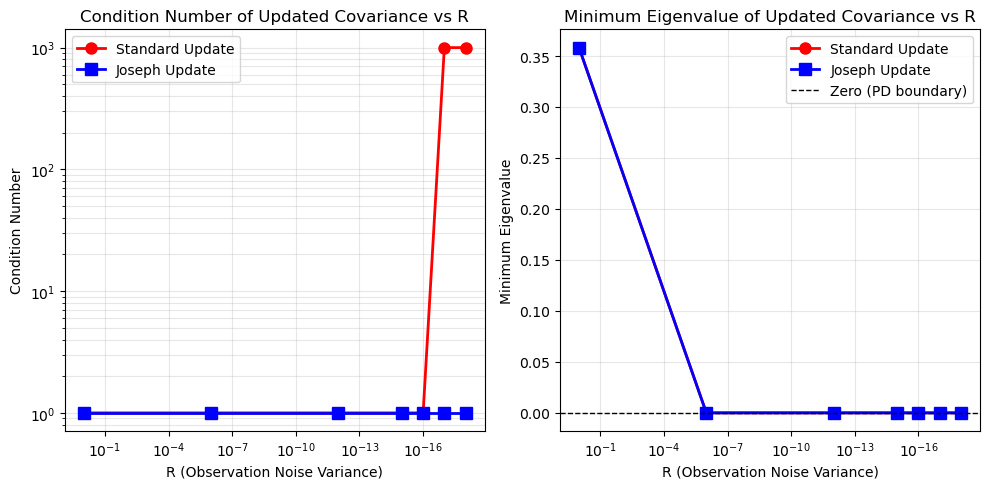

In [4]:
# Plot the results
plot_conditioning_analysis(results)